# 국민청원 데이터로 이진 분류하기

* 예제로 응답여부를 0과 1로 예측합니다.
* 응답여부 외에도 청원의 카테고리를 예측하는 분류를 해볼 수도 있을것 같아요. 
* 이 예제를 참고하여 응답여부외에 청원내용으로 평균 이상의 투표를 받을 것인지 여부를 예측해 보면 좋겠습니다.

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [2]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('data/petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(192387, 8)

In [3]:
petitions.describe()

,article_id,answered,votes
count,192387.000000,192387.000000,192387.000000
mean,113937.905035,0.000135,145.026748
std,70999.561497,0.011624,4382.942031
min,21.000000,0.000000,0.000000
25%,49908.500000,0.000000,1.000000
50%,111144.000000,0.000000,3.000000
75%,173456.500000,0.000000,10.000000
max,242902.000000,1.000000,615354.000000


In [4]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 10만건 이상 데이터도 제거합니다.
df = petitions.loc[(petitions['votes'] > 1000) & (petitions['votes'] < 1000000)]
df.shape

(1687, 8)

In [5]:
df.describe()

,article_id,answered,votes
count,1687.000000,1687.000000,1687.000000
mean,129882.737404,0.015412,14519.085359
std,71267.473739,0.123221,44530.991294
min,28.000000,0.000000,1002.000000
25%,65556.500000,0.000000,1585.500000
50%,139835.000000,0.000000,2862.000000
75%,188582.500000,0.000000,7637.500000
max,242889.000000,1.000000,615354.000000


In [6]:
# 1000건 이상 투표를 받은 데이터의 평군은 7595 입니다. 
df.loc[df['answered'] == 1].shape

(26, 8)

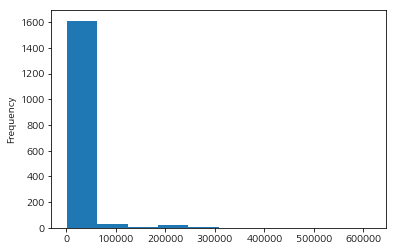

In [7]:
%matplotlib inline 
df['votes'].plot.hist()

In [8]:
# 기본값을 0으로 세팅
df['votes_pos_neg'] = 0

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
# 투표수가 평균을 넘으면 1로 다시 세팅
df['votes_pos_neg'] = (df['votes'] > 1676) == 1

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
# 타입을 boolean 에서 int로 변경해 줍니다.
df['votes_pos_neg'] = df['votes_pos_neg'].astype(int)

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
df.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,1
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",1
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",1
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,0
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,0


In [12]:
# 샘플로 보고 싶은 인덱스의 번호를 넣어주세요.
sample_index = 38

In [13]:
sample_title = df['title'][sample_index]
sample_title

'영어회화전문강사제도는 유지되어야합니다.'

In [14]:
sample_content = petitions['content'][sample_index]
sample_content

'1. 영전강의고용안정을 원합니다\\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니다\\n3. 성과급 호봉인정 상여금 급식비지원 전혀없으며 연봉인상 또한 없습니다\\n4.인권위의 무기직으로 전환 권고받았습니다\\n5.공공부문 비정규직 없애는건 문정부의 공약이며 이에따라 영전강만 제외하는것은 불공평합니다\\n저희는 정교사나 정규직을 원하는것이 아닙니다.\\n이 일을 계속 하길 희망할 뿐입니다.  문재인대통령님께선 일자리창출을 매우 중요하게 생각하셨습니다.  일자리창출 만큼 중요한것이 일자리 유지입니다.  창출만 하고 유지가 되지 않는다면 그저  형식적인 정책일 뿐입니다. 하루빨리 결과가 나와  안정된 마음으로 일하고 싶습니다.  감사합니다.'

# 전처리 하기 

In [15]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [16]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [17]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [18]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [19]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 210 ms, sys: 5.06 ms, total: 215 ms
Wall time: 217 ms


/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 351 ms, sys: 4.9 ms, total: 356 ms
Wall time: 354 ms


/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [21]:
df = df.reindex()

In [22]:
df.shape

(1687, 11)

In [23]:
split_count = int(df.shape[0] * 0.7)
split_count

1180

In [24]:
df_train = df[:split_count]
df_train.shape

(1180, 11)

In [25]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,1,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",1,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",1,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,0,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,0,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...


In [26]:
# 학습 세트에서 투표수가 평균보다 많은 건
df_train.loc[df_train['votes_pos_neg'] == 1].shape

(848, 11)

In [27]:
df_test = df[split_count:]
df_test.shape

(507, 11)

In [28]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2
148370,178795,2018-03-28,2018-04-27,0,9096,미래,"★★★하남 자족U2(8-3,4,5,6) 이마트 대형 물류센터건립 절대 반대 합니다★★★",관련 기사입니다\nhttp://daily.hankooki.com/lpage/econ...,1,관련 기사입니다 http daily hankooki com lpage econo...,관련 기사입니다 http daily hankooki com lpage econo...
148387,178819,2018-03-28,2018-04-27,0,3270,기타,실적압박으로 인한 자살 기억하시는지요...현재도 진행형입니다..,안녕하십니까.\nkt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다\n알고계실지...,1,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...
148492,178954,2018-03-28,2018-04-27,0,2030,안전/환경,김부겸 행정안전부 장관님께 정확한 사실관계 확인 부탁드립니다.,"道 기획조정실, 일방적 사업 축소 반발 일자 신규채용 관련 감사도\n소방관들 “업무...",1,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...
148635,179146,2018-03-29,2018-04-28,0,16216,보건복지,저희 엄마 사망의 진실을 알려주십시오,저는 며칠 전 병원에서 엄마를 잃었습니다.\n그런데 병원측의 너무나 어처구니 없는 ...,1,저는 며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 없는 대...,며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 대처로 억울하...
148648,179162,2018-03-29,2018-04-28,0,6698,육아/교육,총신대 사태의 희생양이된 학생들을 전과자로 만들어서는 결코 안됩니다.,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,1,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 없어...


In [29]:
# 테스트 세트에서 투표수가 평균보다 많은 건
df_test.loc[df_test['votes_pos_neg'] == 1].shape

(370, 11)

# 단어 벡터화 하기

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [31]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 3.05 s, sys: 113 ms, total: 3.16 s
Wall time: 3.17 s


In [32]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 1.31 s, sys: 43.4 ms, total: 1.36 s
Wall time: 1.36 s


In [33]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'and',
 'article',
 'as',
 'co',
 'co kr',
 'co kr news',
 'com',
 'com main',
 'com main read']

In [34]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,and,article,as,co,co kr,co kr news,com,com main,com main read,...,후에,후에도,훨씬,휴게시간,힘든,힘들게,힘들어,힘없는,힘을,힘이
0,41,35,63,50,50,19,19,115,109,47,...,25,42,33,70,32,20,22,19,43,25


In [35]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [36]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 5.07 ms, sys: 2.18 ms, total: 7.25 ms
Wall time: 6.13 ms


In [37]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 3.68 ms, sys: 1.63 ms, total: 5.32 ms
Wall time: 4.78 ms


In [38]:
test_feature_tfidf.shape

(507, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [39]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [40]:
# 학습에 사용할 y_label 을 넣어준다.
y_label = df_train['votes_pos_neg']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 1.17 s, sys: 37.9 ms, total: 1.21 s
Wall time: 511 ms


# 평가하기

In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

scoring = 'accuracy'
score = cross_val_score(forest, train_feature_tfidf, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

array([0.62711864, 0.75423729, 0.66949153, 0.71186441, 0.75423729,
       0.73728814, 0.6779661 , 0.72033898, 0.66101695, 0.70338983])

In [42]:
round(np.mean(score)*100,2)

70.17

# 예측

In [43]:
# 테스트 데이터를 넣고 예측한다.
y_pred = forest.predict(test_feature_tfidf)
y_pred[:10]

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 0])

In [44]:
y_pred.shape

(507,)

In [45]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'votes_pos_neg_pred':y_pred})
output.head()

,votes_pos_neg_pred
0,1
1,1
2,0
3,1
4,1


In [46]:
# 0과 1이 어떻게 집계 되었는지 확인한다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었다.
output['votes_pos_neg_pred'].value_counts()

1    281
0    226
Name: votes_pos_neg_pred, dtype: int64

In [47]:
df_test['votes_pos_neg_pred'] = y_pred

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
df_test['pred_diff'] = df_test['votes_pos_neg'] - df_test['votes_pos_neg_pred']
df_test.head()

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2,votes_pos_neg_pred,pred_diff
148370,178795,2018-03-28,2018-04-27,0,9096,미래,"★★★하남 자족U2(8-3,4,5,6) 이마트 대형 물류센터건립 절대 반대 합니다★★★",관련 기사입니다\nhttp://daily.hankooki.com/lpage/econ...,1,관련 기사입니다 http daily hankooki com lpage econo...,관련 기사입니다 http daily hankooki com lpage econo...,1,0
148387,178819,2018-03-28,2018-04-27,0,3270,기타,실적압박으로 인한 자살 기억하시는지요...현재도 진행형입니다..,안녕하십니까.\nkt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다\n알고계실지...,1,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...,안녕하십니까 kt 통신사 고객센터에 근무하는 와이프를 둔 가장입니다 알고계실지 모...,1,0
148492,178954,2018-03-28,2018-04-27,0,2030,안전/환경,김부겸 행정안전부 장관님께 정확한 사실관계 확인 부탁드립니다.,"道 기획조정실, 일방적 사업 축소 반발 일자 신규채용 관련 감사도\n소방관들 “업무...",1,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...,0,1
148635,179146,2018-03-29,2018-04-28,0,16216,보건복지,저희 엄마 사망의 진실을 알려주십시오,저는 며칠 전 병원에서 엄마를 잃었습니다.\n그런데 병원측의 너무나 어처구니 없는 ...,1,저는 며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 없는 대...,며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 대처로 억울하...,1,0
148648,179162,2018-03-29,2018-04-28,0,6698,육아/교육,총신대 사태의 희생양이된 학생들을 전과자로 만들어서는 결코 안됩니다.,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,1,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 없어...,1,0


In [49]:
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

 0    268
 1    164
-1     75
Name: pred_diff, dtype: int64

In [50]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[0]))

전체 507건의 데이터 중 268건 예측


In [51]:
acc = ( pred_diff[0] / y_pred.shape[0] ) *100 
print('예측 비율 {}'.format(acc))

예측 비율 52.85996055226825
